In [1]:
from scripts.model import MLP_drug_cell_permutate
from scripts.evaluation import calculate_accuracy 
from scripts.util import DrugCombDataset_customized 
from scripts.active_learning_utils import get_datasets_simple_constraint_v2, selec_data, get_datasets_simple, func_lambd, calculate_derivative
from scripts.train_model import run_one 
import joblib 
import numpy as np 
import pandas as pd 
import argparse 
import os 
import torch 
import random 
import matplotlib.pyplot as plt 
from time import time 

### Define parameters

In [2]:
study_name = 'oneil'
# number of samples which are added  in each round for active learning 
num_drugs = 50
num_step_limit = 5 
# the device that you would use to run your code 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# data folder 
data_folder_path = "./data/" + str(study_name) + '/'
synergy_score = "loewe"

# folder to save your results 
save_folder = "results/sample_" + str(num_drugs) + "/" + str(study_name) + '/'

os.makedirs(save_folder, exist_ok=True)

# 
cell_feature = 'ge'
drug_feature = 'morgan'

# flag_stop: True, if you would like to stop active learning at your setting round 
flag_stop = True 

# default permutation operation 
operation = 'additive'

# batch_size: the batch_size for training mlp model 
batch_size = 32


the study name:  oneil  the sample selection strategy:  exploration


### Choose the selection strategy 

In [13]:
# flag_acquisition: 'exploration', 'exploitation', 'random' or 'hybrid'
flag_acquisition = 'exploration' 
print('the study name: ', study_name, ' the sample selection strategy: ', flag_acquisition)

the study name:  oneil  the sample selection strategy:  exploration


### Load data 

In [3]:
# ------------------------- Load data -----------------------------------
# load data, cell feature and drug features 

dataset = pd.read_feather(data_folder_path + f"/{synergy_score}.feather")
cell_lines = pd.read_feather(data_folder_path + "cell_lines_" + str(cell_feature) + ".feather").set_index("cell_line_name")
cell_lines = cell_lines.astype(np.float32)
mol_mapping = joblib.load(data_folder_path + 'mol_' + str(drug_feature) +'_dic.joblib')

train_dataset_tmp, val_dataset, flag =  get_datasets_simple(study_name = study_name, dataset =dataset)

drug_dim = mol_mapping['shape']
cell_dim = cell_lines.shape[1]

print('drug_dim and cell_dim: ', drug_dim, cell_dim)
print(device)
print(study_name, flag_stop, flag_acquisition)

drug_dim and cell_dim:  1024 908
cpu
oneil True exploration


### Hyperparameter define 


In [4]:
# ------------------------- define hyperparameters -----------------------------------

hparam = {
    'drug_dim': drug_dim, 
'cell_dim': cell_dim,
'hid_dim_1': 2**8,
'hid_dim': 2**7,
'lr': 1e-4,
'wd': 1e-6,
'max_epoch': 100,
'device': device,
'test_dataset': val_dataset,
'num_drug': num_drugs,
'batch_size': batch_size,
'cell_lines': cell_lines, 
'mol_mapping': mol_mapping,
'drugs_feature': drug_feature,
'cell_feature': cell_feature,
'operation': operation 
}

In [5]:
start_time = time()
# ------------------------- define hyperparameters -----------------------------------

hparam = {
    'drug_dim': drug_dim, 
'cell_dim': cell_dim,
'hid_dim_1': 2**8,
'hid_dim': 2**7,
'lr': 1e-4,
'wd': 1e-6,
'max_epoch': 100,
'device': device,
'test_dataset': val_dataset,
'num_drug': num_drugs,
'batch_size': batch_size,
'cell_lines': cell_lines, 
'mol_mapping': mol_mapping,
'drugs_feature': drug_feature,
'cell_feature': cell_feature,
'operation': operation 
}
# initial training 
final_results = {}
# ------------------------- run the active learning for 5 times -------------------------------------
for iter in range(2):
    left_data, train_dataset_initial, flag = get_datasets_simple_constraint_v2(fold_number = 0, dataset = train_dataset_tmp, step_add= num_drugs, study_name=study_name)
    max_fold = 5 
    sigma_pred, results, mean_pred = run_one(train_dataset_initial, left_data, max_fold, hparam)
    step_results = results + [len(train_dataset_initial)] + [train_dataset_initial.target.sum(), train_dataset_initial.target.sum()]
    print(step_results)
    results_all = [step_results]
    step = 1 
    lambd =  func_lambd(np.nan, np.nan, flag_acquisition)
    while flag:
        if flag_acquisition != 'random':
            pred_comb = lambd*sigma_pred + (1- lambd) * mean_pred 
        else:
            pred_comb = [random.random() for el in range(len(left_data))] 

        
        left_data , train_dataset_add, flag = selec_data(pred_comb, left_data,  num_drugs, flag_early_stop=flag_stop, num_step = step, num_step_limit = num_step_limit)
        

        train_dataset_initial = pd.concat([train_dataset_initial, train_dataset_add])
        sigma_pred, results, mean_pred = run_one(train_dataset_initial, left_data, max_fold, hparam, flag = flag)
        step_results = results + [len(train_dataset_initial)]+ [train_dataset_initial.target.sum(), train_dataset_add.target.sum()]
        print(step_results)
        print('add N data: ', len(train_dataset_add))
        results_all += [step_results]
        d_pos, d_current = calculate_derivative(results_all)  
        lambd = func_lambd(d_pos, d_current, flag_acquisition)
        print(d_pos, d_current, lambd)
        step += 1

    
    final_results[iter] = results_all
joblib.dump(final_results, save_folder + str(flag_acquisition) + '.joblib')
end_time = time()

print('---------the time needed: ', end_time - start_time, '--------')


epoch = 0 with training loss: 0.723505437374115, test accuracy: [0.4801652266181598, 0.029087110823743344, 0.029781601588352084, 0.029781601588352084, 1.0, 0.0]
epoch = 0 with training loss: 0.7228240966796875, test accuracy: [0.47614824920418375, 0.02896164558278095, 0.029781601588352084, 0.029781601588352084, 1.0, 0.0]
epoch = 0 with training loss: 0.7216373682022095, test accuracy: [0.4775807185084129, 0.029110664175399134, 0.029781601588352084, 0.029781601588352084, 1.0, 0.0]
epoch = 0 with training loss: 0.7182737588882446, test accuracy: [0.4772320751856904, 0.02900312207259341, 0.029781601588352084, 0.029781601588352084, 1.0, 0.0]
epoch = 0 with training loss: 0.7133951187133789, test accuracy: [0.4727755040169775, 0.028457344940548402, 0.029781601588352084, 0.029781601588352084, 1.0, 0.0]
epoch = 1 with training loss: 0.7029716968536377, test accuracy: [0.49005608609974227, 0.030176756024577624, 0.029781601588352084, 0.029781601588352084, 1.0, 0.0]
epoch = 1 with training loss:

# Plot the results on yield and accuracy

In [5]:
import joblib 
import matplotlib.pyplot as plt 
import fnmatch
import numpy as np 
import pandas as pd 
import matplotlib.colors as mcolors 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
COLORS_L = ['#4A90E2', '#417505', '#FF6F61', 'k']

In [8]:

def plot_one_result_1(results_optimal, axes, color, label, num_data = 896, linestyle='solid', marker = None):
    indices = list(results_optimal.keys())
    
    results = []
    for iter in indices:
        if len(results_optimal[iter][0]) == 4:
            for el in range(len(results_optimal[iter])):
                previs = results_optimal[iter][el] 
                results_optimal[iter][el] = [ele for ele in previs[0]] + previs[1:]
        results += [np.array(results_optimal[iter])[:,-2]]
    data_sizes =  np.array(results_optimal[0])[:, -3]
    df = pd.DataFrame(np.array(results), columns = np.array(results_optimal[0])[:, -3], index = indices)
    x_ = [int(el)- num_data for el in data_sizes]

    y = np.array(df.mean(axis = 0))
    y_std = np.array(df.std(axis = 0))
    axes.plot(x_ , y, c= color, label = label, linestyle=linestyle, linewidth=2.0, marker = marker, markersize=4) 
    axes.fill_between(x_, y-y_std, y+y_std,
        alpha=0.2, edgecolor=color, facecolor=color,
        antialiased=True)


def plot_one_result_2(results_optimal, axes, color, label, num_data = 896, linestyle='solid', marker = None):
    indices = list(results_optimal.keys())
    
    results = []
    for iter in indices:
        if len(results_optimal[iter][0]) == 4:
            for el in range(len(results_optimal[iter])):
                previs = results_optimal[iter][el] 
                results_optimal[iter][el] = [ele for ele in previs[0]] + previs[1:]
        results += [np.array(results_optimal[iter])[:,1]]
    data_sizes =  np.array(results_optimal[0])[:, -3]
    df = pd.DataFrame(np.array(results), columns = np.array(results_optimal[0])[:, -3], index = indices)
    # x_ = [int(el/num_data) for el in data_sizes]
    x_ = [int(el) - num_data for el in data_sizes]
    y = np.array(df.mean(axis = 0))
    y_std = np.array(df.std(axis = 0))
    axes.plot(x_, y, c= color, label = label, linestyle=linestyle, linewidth=2.0, marker = marker, markersize=4) 
    axes.fill_between(x_, y-y_std, y+y_std,
        alpha=0.2, edgecolor=color, facecolor=color,
        antialiased=True)

    

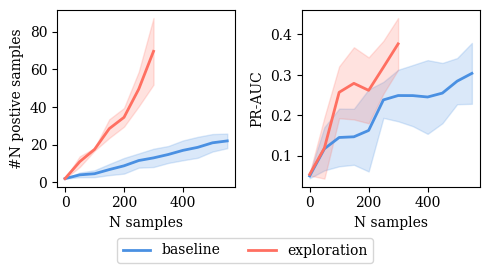

In [12]:
study_name = 'oneil'
num_data = 50 
strategy = 'exploration'
save_folder = './results/sample_' + str(num_data) + '/' + str(study_name)
results_random = joblib.load(str(save_folder) + '/random.joblib')
results_active = joblib.load(str(save_folder) + '/' + str(strategy) + '.joblib')
fig, axes = plt.subplots(1, 2, figsize = (5, 2.5))
plot_one_result_1(results_random, axes[0], color = COLORS_L[0], label= 'baseline', num_data=num_data)
plot_one_result_1(results_active, axes[0], color = COLORS_L[2], label= str(strategy),num_data=num_data)

plot_one_result_2(results_random, axes[1], color = COLORS_L[0], label= 'baseline',num_data=num_data)
plot_one_result_2(results_active, axes[1], color = COLORS_L[2], label= str(strategy), num_data=num_data)

axes[0].set_xlabel('N samples')
axes[1].set_xlabel('N samples')
axes[0].set_ylabel('#N postive samples')
axes[1].set_ylabel('PR-AUC')



handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol = 5,  bbox_to_anchor = (0, -0.1, 1, 1))
# fig.suptitle(study_name)
fig.tight_layout()
fig.show()